In [12]:
from src import import_functions, data_filtering_functions, clustering_functions, assignment_functions
import pandas as pd

## Import Benthosdatenbanken

In [4]:
input_files = ['DatenExport_AWI_critterbase_20220623_MK_TB.xlsx',
               'DatenExport_DB_Nordsee_20220623_MK_TB.xlsx',
               'DatenExport_GesammelteProjekte_20220623_MK_TB.xlsx']
input_files = ['./data/01_benthos_db/'+x for x in input_files]
HAUL_DB = import_functions.multiple_excel_to_gdf(input_files)
HAUL_DB = pd.concat(HAUL_DB)
print(HAUL_DB.head())

  ST_ID   Haul_ID  PARALLELNO  GEOLATSTARTHL  GEOLONSTARTHL  \
0   nan  K1-506-1         3.0      54.566788       7.916522   
1   nan  K1-506-1         3.0      54.566788       7.916522   
2   nan  K1-506-1         3.0      54.566788       7.916522   
3   nan  K1-506-1         3.0      54.566788       7.916522   
4   nan  K1-506-1         3.0      54.566788       7.916522   

          SAMPLINGINSTR ScientificName_Accepted  APHIA_ID_accepted  \
0  van Veen Greifer 0,1                 Ophelia             129413   
1  van Veen Greifer 0,1       Spio goniocephala             131184   
2  van Veen Greifer 0,1    Goniadella bobrezkii             130143   
3  van Veen Greifer 0,1                Anthozoa               1292   
4  van Veen Greifer 0,1       Orbinia sertulata             130523   

   SPECIMENHAUL  WETWPROBE                  geometry  
0          46.0    2339.90  POINT (7.91652 54.56679)  
1          17.0     101.50  POINT (7.91652 54.56679)  
2           6.0       9.70  POINT (

## Aufbereitung der Datensätze

In [15]:
#bu = HAUL_DB.copy()
HAUL_DB = bu
HAUL_DB = HAUL_DB.sample(frac=0.1)

In [6]:
HAUL_DB = data_filtering_functions.apply_specific_filter_haul_db(HAUL_DB)
HAUL_DB = data_filtering_functions.replace_placeholders(HAUL_DB)
HAUL_DB.to_pickle('HAUL_DB.pkl') 

DB-entries: 201412
-> Ignore "Phoronis" entries: 201412
-> Ignore dublicates: 201395

Replace placeholders in dict_keys(['SPECIMENHAUL', 'WETWPROBE'])


## Fuzzy-K-Medoid-Clustering

running settings labelled as  E-RP-7


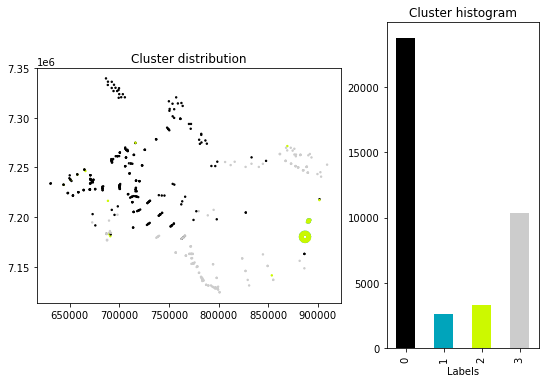

running settings labelled as  S-RP-3


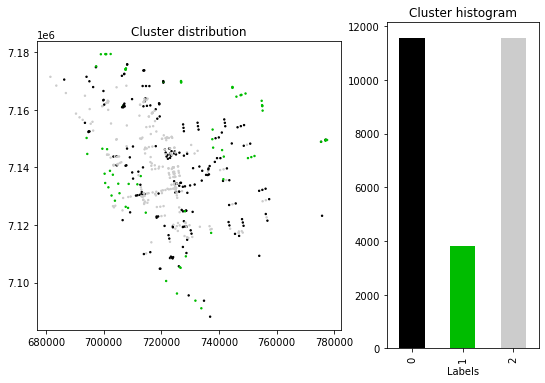

In [10]:
HAUL_DB = pd.read_pickle('HAUL_DB.pkl')
settings = dict({# Entenschnabel
                 #'NW-RP-4': {'consistency':0.02, 'method':'FKM', 'transformation':'HF_Euc', 'ncluster': 2, 'fuzzyfication': 1.3},
                 # Sylter Außenriff
                 #'NE-RP-4': {'consistency':0.02, 'method':'FKM', 'transformation':'HF_Euc', 'ncluster': 2, 'fuzzyfication': 1.1},
                 # Elbe-Urstromtal
                 'E-RP-7' : {'consistency':0.02, 'method':'FKM', 'transformation':'HF_Euc', 'ncluster': 4, 'fuzzyfication': 1.2},
                 # Borkum-Riffgrund
                 'S-RP-3' : {'consistency':0.02, 'method':'FKM', 'transformation':'HF_Euc', 'ncluster': 3, 'fuzzyfication': 1.1}
})            
clustering_functions.run_specific_cluster_settings(settings)

## Zuweisung von Charakterarten

In [13]:
character_stat_scores = {"ND":0.03,"AT":0.6,"P":0.6,"PT":0.6,"T":8,"Threshold_Sum":3} 
assignment_functions.run_assignment_for_cluster_runs(character_stat_scores)

E-RP-7 623
Cluster  0
Cluster  1
Cluster  2
Cluster  3
S-RP-3 561
Cluster  0
Cluster  1
Cluster  2


In [14]:
assignment = pd.read_csv('character_selection.csv',skip_blank_lines=True)
assignment.columns = assignment.columns.str.replace("\n ", "")
assignment = assignment[assignment['Species'].str.contains('Species') == False]

In [19]:
assignment.loc[(assignment['run'] == 'S-RP-3') & (assignment['CL_ID'] == '2')]

,Species,run,CL_ID,simper_sd,total_count,total_sum,cl_count,cl_sum,ND,AT,P,PT,T,ND_Q,AT_Q,P_Q,PT_Q,T_Q,Sum_Q
33,Aonides paucibranchiata,S-RP-3,2,0.14263717429019981,346.0,10564.0,263.0,10326.0,0.284040270671728,0.9774706550549035,0.9740740740740741,0.7601156069364162,1,1,1,1,1,1,5
34,Asteroidea,S-RP-3,2,0.0864717845193914,42.0,3324.0,22.0,2960.0,0.08142157671783022,0.8904933814681107,0.08148148148148149,0.5238095238095238,4,1,1,0,0,1,3
35,Branchiostoma lanceolatum,S-RP-3,2,0.08904966325205842,243.0,3311.0,210.0,3263.0,0.08975628541563514,0.9855028692237995,0.7777777777777778,0.8641975308641975,3,1,1,1,1,1,5
36,Glycera lapidum,S-RP-3,2,0.027712292459777417,207.0,1401.0,170.0,1336.0,0.0367497386807504,0.953604568165596,0.6296296296296297,0.821256038647343,17,1,1,1,1,0,4
37,Goodallia triangularis,S-RP-3,2,0.08042059928194494,236.0,1802.0,184.0,1657.0,0.045579578588325904,0.9195338512763596,0.6814814814814815,0.7796610169491526,6,1,1,1,1,1,5
38,Loimia ramzega,S-RP-3,2,0.035372345519012784,106.0,1370.0,81.0,1287.0,0.035401881498597125,0.9394160583941605,0.3,0.7641509433962265,15,1,1,0,1,0,3
39,Notomastus,S-RP-3,2,0.057032591373372056,99.0,1664.0,93.0,1654.0,0.04549705672003081,0.9939903846153846,0.34444444444444444,0.9393939393939394,8,1,1,0,1,1,4
